# Bacterial Bomb - Model to Track Contamination

**This model has been designed to track the fallout of a biological weapon that has been detonated on top of a building. The code used to build the model is detailed in this notebook.**

Docstrings detailing Classes, methods and functions can be found at ENTER LINK

---------

First import all the packages that will be needed to run the program. Instructions to install `pandas` and `seaborn` with Anaconda can be found here: 
https://anaconda.org/anaconda/pandas 
https://anaconda.org/anaconda/seaborn

In [39]:
import csv                      #to allow raster data to be read
import random                   #for random number generating
import matplotlib.pyplot as plt #for plotting spread 
import particle_framework       #the particle class created 
import pandas as pd             #for density map data frame
import seaborn as sns           #for creating density map 
import time                     #to time spreading of particles

## Build the `Particle` Class

Create the `Particle` Class which will be used as a framework and to initialise the particles. The class will enable the particles to spread either North, South, East or West depending on the directional probablities set. It will also enable them to rise up or fall down to the ground, again depending on the turbulance probabilities set. 

In [28]:
class Particle:
    #'fix' the random numbers so outputs stay constant, can change the seed arg
    random.seed(0)
    def __init__(self, town, particles, y, x):
        
        #the initial starting point for each particle is at the bomb location
        self.y = 150 
        self.x = 50
            
        self.town = town  #giving every agent access to the map of the town
        self.toxicity = 70 #base toxicity is 70 and will increase later        #TODO
        self.particles = particles #every particle access to 'particles' list
        self.height = 75 #all particles initial height = building height 75m 
        
        
    def __repr__(self):
        
        return str([self.x, self.y]) #used to print initial & moved particles
       
    
    def spread(self, p_east, p_west, p_north, p_south):
        
        chance = random.randint(1, 100) #select a random integer between 1-100 
        
        if chance <= p_east:
            self.x = self.x + 1 #move east 75% chance default or value entered
            
        elif (p_east < chance <= p_east + p_west):
            self.x = self.x - 1 #move west 5% chance default or value entered 
            
        elif (p_east + p_west < chance <= p_east + p_west + p_north):
            self.y = self.y + 1 #move north 10% chance default or value entered
        
        elif (p_east + p_west + p_north < chance <= p_east + p_west + p_north + p_south): 
            self.y = self.y - 1 #move south 10% chance default of value entered 
            
        #Town is non abstract landscape, particles cannot follow torus boundary
        #Create solid wall boundary, check if particle off edge & adjust
        if self.x < 0:   #if x, y hit 0, stop from going below 0 
            self.x = 0
        if self.y < 0:
            self.y = 0
        if self.x > 300:  #if x, y hit 299 (300x300 is town dimension),
            self.x = 300  #stop from going any higher
        if self.y > 300:
            self.y = 300
        
            
    def turbulance(self, p_rise, p_same, p_fall):
        
        chance = random.randint(1, 100) #select a random integer between 1-100 
               
        if self.height >= 75: #for particles ABOVE the building height of 75m
            #particle rises, 20% default chance or value entered
            if chance <= p_rise:
                self.height = self.height + 1  
                
            #particle stays at same level, 10% chance or value entered   
            elif (p_rise < chance <= p_rise + p_same):
                self.height = self.height   
            
            #particle falls, 70% default chance of value entered    
            elif (p_rise + p_same < chance <= p_rise + p_same + p_fall):
                self.height = self.height - 1
                      
        elif (0 < self.height < 75):  #for particles BELOW the building height
            self.height = self.height - 1  #falls until hits the ground at 0m

## 1. Pull in the `wind.raster` data file and find out the bombing location

First the the raster data file needs to be read and processed. 

In [29]:
# Setting up town
f = open ('wind.raster', newline='') #read in data from raster file
#csv.reader gives data as list of list to be looped through
dataset = csv.reader (f, quoting=csv.QUOTE_NONNUMERIC) #converts no. to floats

town = [] #empty town list to add the rowlist elements (mutable)

for row in dataset:
    rowlist = [] #empty list to add each row as an element
    for value in row:
        rowlist.append (value) #adds each row's data as its own rowlist element
    town.append (rowlist)  #each rowlist added to environ list, 2D now 
f.close() 	#file closed after reading data

Now the location of the building where the bomb was detonated can be identified.

In [30]:
# Locating the bomb detonation point
counter = 0 #start a counter for the rows in the town list
for row in town: #both for loops to check through every value in the 2D list
    for value in row:
        if value != 0: #if the value is not equal to zero, then set bomb coords 
            bomb_x = row.index(value) #bomb x coord
            bomb_y = counter 
            #will print the coord of the only non zero pixel value (255)
            print("Coords of the building where bomb detonated:",(bomb_x, bomb_y))
    #step the row counter by 1 to loop through all rows until non zero found
    counter += 1

Coords of the building where bomb detonated: (50, 150)


Plot the raster data so that a map of the town can be outputted as a figure, with the bomb location marked.

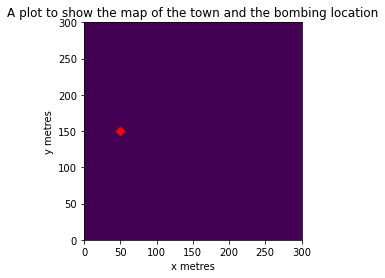

In [31]:
# Plotting the raster data
plt.ylim (0, 300) #setting graph axis 300x300 to match raster
plt.xlim (0, 300)
plt.title ('A plot to show the map of the town and the bombing location')
plt.xlabel('x metres') #graph axis labels, 1 pixel = 1 metre
plt.ylabel('y metres')
#mark the bomb location with a red diamond overlay 
plt.scatter (50, 150, color='red', marker=('D'))
#plotting map of the area/town and bombing location
plt.imshow(town) 

The figure outputted above should look like this image: 
<img src="initial_town.png">


## 2. Calculate where 5000 bacteria will end up

Initialise/create the particles using the Particles class.

In [41]:
# Major model parameters
num_of_particles = 5000
num_of_iterations = 100 #i.e after 700 seconds, 11mins

#Chances/probability of wind blowing particle in different directions
p_east = 75  #75 means 75% chance particle moves east each second/iteration 
p_west = 5   #NESW probs can be integer or decimal/float, just need sum = 100
p_north = 10
p_south = 10

#Chances of wind turbulance effects 
p_rise = 20 #20% chance particle rises 1m per second (1 pixel per iteration)
p_same = 10 #particle stays at the same level
p_fall = 70 #probs can be integer or decimal/float, just need sum = 100



particles = [] #empty list to add Partical class instances

print ("Initialising particles--") 
# Creating particles and adding to particles list

for i in range(num_of_particles): 
    y = 150
    x = 50
    #passing in data from town & particles list and y,x and appending to list
    particles.append (particle_framework.Particle(town, particles, y, x)) 

Initialising particles--


To move the particles that have just been created, the `spread` and `turbulance` methods from the `Particles` class will need to be used. This replicates the effects that the wind and turbulance, in a real town, would have on the particles. The bacteria particles spread either North, East, South or West. The turbulance means that particles may rise upwards, but they will all eventually fall down to the ground.

In [42]:
print ("Spreading bomb particles--")
# Particles spread across town either NESW directions and rise/fall 
start = time.perf_counter() #start clock to assess efficiency 
    
#Methods in Particles class act on every element in particles list
for i in range (num_of_particles): 
    
    #only run methods when the height of the particle is not 0 ie. not on ground
    seconds_count = 0 #to count the no of seconds/times while loop runs
    while particles[i].height != 0:
        
        seconds_count += 1 #increment by 1 every loop iteration, 1 iter = 1 sec
        particles[i].spread(p_east, p_west, p_north, p_south) #NESW movement
        particles[i].turbulance(p_rise, p_same, p_fall) #up/down movement

end = time.perf_counter() #end the timer for the calculating distances loops
print ("All particles have now settled on the ground")
print ("Time taken to calculate particles reaching ground = " + str (end - start))
print ("Time taken for particles to actually hit the ground in the town = "+str(seconds_count)+" seconds")

Spreading bomb particles--
All particles have now settled on the ground
Time taken to calculate particles reaching ground = 2.7008810000006633
Time taken for particles to actually hit the ground in the town = 75 seconds


Plot these particles after spreading to visualise the movement.

In [ ]:
plt.ylim (0, 300) #setting graph axis 300x300 to match raster
plt.xlim (0, 300)
plt.title ('A plot to show the map of the town and the particle contamination')
plt.xlabel('x metres') #graph axis labels, 1 pixel = 1 metre
plt.ylabel('y metres')
#mark the bomb location with a red diamond overlay 
plt.scatter (50, 150, color='red', marker=('D'))
#plotting map of the area/town and bombing location
plt.imshow(town) 

for i in range (num_of_particles):
    #ith obj from particles list, using Particles Class to specify x, y coords
    plt.scatter (particles[i].x, particles[i].y) 
#figure caption
txt= "Fig 1. End locations of "+str(num_of_particles)+" particles in the town after "+str(seconds_count)+" seconds"
plt.figtext(0.5, 0.0001, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.show() 

If all the default major model parameters have remained unchanged, the figure outputted about should look like:
<img src="town_after_spread.png">

Output the end locations of all the bacteria particles after they have reached the ground. The output file format is a `.txt` text file.

In [35]:
f = open("end_locations.txt",'w', newline='') #builtin open func to write end coords
for line in particles: #for every line in particles list
    f.write (repr(line)) #write as a string in the text file
f.close() #file closed after writting the coords

## 3. Draw a density map of where all the bacteria end up as an image and display it

To draw a density map, first the x and y data of the particles are separated into two lists, and a disctionary is created with these. Using the `pandas` package, the dictionary forms the dataframe to be used for a density plot. The density plot is created and saved using the `seaborn` package.

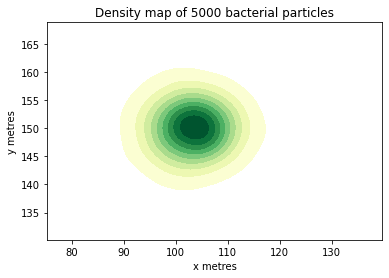

In [36]:
# Creating separate lists for all x & y end locations for density plot
all_x_data = []  #empty list for all x and y coords to go into
all_y_data = [] 
for i in range (num_of_particles):
    #for every particle, add its corresponding x coord/y coord into the list 
    all_x_data.append (particles[i].x)
    all_y_data.append (particles[i].y)

# Creating dictionary for x, y coords to use as pandas dataframe for density plot
d = {'x': all_x_data,'y': all_y_data} #creating the dictionary of 2 columns 

# Create pandas data frame from the dict and output density map
df = pd.DataFrame(d) #can check by calling d & df in console

plt.figure() #create a 2nd figure output
plt.title ('Density map of ' +str(num_of_particles)+' bacterial particles')
plt.xlabel('x metres') #graph axis labels, 1 pixel = 1 metre
plt.ylabel('y metres')

# Density plot using seaborn, darker green = very dense, yellow = less dense
density = sns.kdeplot(x= df.x, y= df.y, cmap='YlGn',shade=True,bw_method=0.5) 
density.figure.savefig("density_map.png") #save as an image file

If all the default major model parameters have remained unchanged, the figure outputted about should look like:
<img src="density_map.png">

## 4. Save the density map to a file as text

To begin with, it has to be determined how many particles have landed on each pixel in the town map. The density is recorded by adding 1 to the town pixels where a particle has landed. The output `.txt` text file will have `0`'s where no particles are present and for example, a pixel value of `20` where 20 particles have landed at that location on the town. This gives a density map in a plain text format. 

In [37]:
# Save density map to file as text
for i in range (num_of_particles):  #for every particle
    #for every particles y, x coords in the town, add 1 to the town pixel.
    #the town pixel values will represent the no of particles/density there
    town[particles[i].y][particles[i].x] += 1 

f = open('density_map_text.txt', 'w', newline='') #create new text file
writer = csv.writer(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
#for every row in the town list, write that row to the new txt file
for line in town:
    writer.writerow(line) 
f.close() #close the file  